In [4]:
import os
#os.chdir('/Users/rupesh.karn/Desktop/WorkPart-1/UNSW-NB15 Dataset')
import pandas as pd
import numpy as np
import csv
import os
import time
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (16.0, 5.0)

# Read in the training CSV file
print("Reading Training csv file.")
df1 = pd.read_csv("UNSW_NB15_testing-set.csv")
df1.drop('label', axis=1, inplace=True)

obj_df=df1

obj_df["proto"] = obj_df["proto"].astype('category')
obj_df["service"] = obj_df["service"].astype('category')
obj_df["state"] = obj_df["state"].astype('category')
obj_df["proto_cat"] = obj_df["proto"].cat.codes
obj_df["service_cat"] = obj_df["service"].cat.codes
obj_df["state_cat"] = obj_df["state"].cat.codes

obj_df["proto"] = obj_df["proto_cat"]
obj_df["service"] = obj_df["service_cat"]
obj_df["state"] = obj_df["state_cat"]

obj_df.drop('proto_cat', axis=1, inplace=True)
obj_df.drop('service_cat', axis=1, inplace=True)
obj_df.drop('state_cat', axis=1, inplace=True)

Y_train_all_attacks = obj_df["attack_cat"]
obj_df=pd.get_dummies(obj_df, columns=["attack_cat"])


X_train = obj_df.values[:,:-10]


for j in range(0,43):
    maximum = max(X_train[:,j])
    for i in range(0,len(X_train)):
        X_train[i,j] = round(X_train[i,j]/maximum,3)

# Read in the testing CSV file 
print("Reading Testing csv file.")
df2 = pd.read_csv("UNSW_NB15_training-set.csv")
df2.drop('label', axis=1, inplace=True)

obj_df2=df2

obj_df2["proto"] = obj_df2["proto"].astype('category')
obj_df2["service"] = obj_df2["service"].astype('category')
obj_df2["state"] = obj_df2["state"].astype('category')
obj_df2["proto_cat"] = obj_df2["proto"].cat.codes
obj_df2["service_cat"] = obj_df2["service"].cat.codes
obj_df2["state_cat"] = obj_df2["state"].cat.codes

obj_df2["proto"] = obj_df2["proto_cat"]
obj_df2["service"] = obj_df2["service_cat"]
obj_df2["state"] = obj_df2["state_cat"]

obj_df2.drop('proto_cat', axis=1, inplace=True)
obj_df2.drop('service_cat', axis=1, inplace=True)
obj_df2.drop('state_cat', axis=1, inplace=True)

Y_test_all_attacks = obj_df2["attack_cat"]
obj_df2=pd.get_dummies(obj_df2, columns=["attack_cat"])


X_test = obj_df2.values[:,:-10]


for j in range(0,43):
    maximum = max(X_train[:,j])
    for i in range(0,len(X_test)):
        X_test[i,j] = round(X_test[i,j]/maximum,3)


estimators_number = list(range(10,30))

dataspace = 0;
overall_accuracy_matrix = [None]*len(X_train)
iTERATION=0
dataspace_number=1
attack_type = 4
Y_train = obj_df.values[:,-attack_type]
Y_test = obj_df2.values[:,-attack_type]

cleanup_nums = {"Worms":0, "Shellcode":1, "Reconnaissance":2, "Normal":3, "Generic":4, "Fuzzers":5, "Exploits":6, "DoS":7, "Backdoor":8, "Analysis":9}
Y_train_all_attacks.replace(cleanup_nums,inplace=True)
Y_test_all_attacks.replace(cleanup_nums,inplace=True)

Reading Training csv file.
Reading Testing csv file.


In [5]:
%load_ext autoreload
%autoreload 2
%pylab inline

import tensorflow as tf
slim = tf.contrib.slim
graph_replace = tf.contrib.graph_editor.graph_replace

import sys, os
sys.path.extend([os.path.expanduser('..')])
from pathint import utils
import seaborn as sns
sns.set_style("ticks")

from tqdm import trange, tqdm

# import operator
import matplotlib.colors as colors
import matplotlib.cm as cmx

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

select = tf.select if hasattr(tf, 'select') else tf.where

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab', 'maximum', 'array']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
# Data params
input_dim = 43
output_dim = 10

# Network params
n_hidden_units = 43
activation_fn = tf.nn.relu

# Optimization params
batch_size = 64
epochs_per_task = 10

n_stats = 10

# Reset optimizer after each age
reset_optimizer = True

In [7]:
from keras.utils import np_utils

#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9],[1,5],[7,9],[3,8],[0,6],[4,2]]
#task_labels = [[8,9], [6,7], [4,5], [2,3], [0,1]]
#task_labels = [[1,4], [0,9], [7,8], [3,6], [2,5]]
#task_labels = [[0,1,2], [3,4,5], [6,7,8,9]]
#task_labels = [[1,5,8],[2,5,7,9],[3,4,6]]
task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9]]
n_tasks = len(task_labels)
nb_classes  = 10
training_datasets = []
validation_datasets = []
multihead=False

for labels in task_labels:
    idx = np.in1d(Y_train_all_attacks, labels)
    if multihead:
        label_map = np.arange(nb_classes)
        label_map[labels] = np.arange(len(labels))
        data = X_train[idx], np_utils.to_categorical(label_map[Y_train_all_attacks[idx]], len(labels))
    else:
        data = X_train[idx], np_utils.to_categorical(Y_train_all_attacks[idx], nb_classes)
        training_datasets.append(data)

for labels in task_labels:
    idx = np.in1d(Y_test_all_attacks, labels)
    if multihead:
        label_map = np.arange(nb_classes)
        label_map[labels] = np.arange(len(labels))
        data = X_test[idx], np_utils.to_categorical(label_map[Y_test_all_attacks[idx]], len(labels))
    else:
        data = X_test[idx], np_utils.to_categorical(Y_test_all_attacks[idx], nb_classes)
        validation_datasets.append(data)

In [8]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())
import keras.backend as K
import keras.activations as activations

output_mask = tf.Variable(tf.zeros(output_dim), name="mask", trainable=False)

def masked_softmax(logits):
    # logits are [batch_size, output_dim]
    x = select(tf.tile(tf.equal(output_mask[None, :], 1.0), [tf.shape(logits)[0], 1]), logits, -1e32 * tf.ones_like(logits))
    return activations.softmax(x)

def set_active_outputs(labels):
    new_mask = np.zeros(output_dim)
    for l in labels:
        new_mask[l] = 1.0
    sess.run(output_mask.assign(new_mask))
    sess.run(output_mask)
    
def masked_predict(model, data, targets):
    pred = model.predict(data)
    #print(pred)
    acc = np.argmax(pred,1)==np.argmax(targets,1)
    return acc.mean()

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
model = Sequential()
model.add(Dense(60, kernel_initializer='random_uniform', activation=activation_fn, input_shape=(input_dim,)))
#model.add(Dropout(0.2))
model.add(Dense(30, kernel_initializer='random_uniform', activation=activation_fn))
#model.add(Dropout(0.2))
#model.add(Dense(n_hidden_units, activation=activation_fn))
model.add(Dense(output_dim, kernel_initializer='random_uniform', activation=masked_softmax))

from pathint import protocols
from pathint.optimizers import KOOptimizer
from keras.optimizers import Adam, RMSprop,SGD
from keras.callbacks import Callback
from pathint.keras_utils import LossHistory
from keras.callbacks import History 
from keras.callbacks import LambdaCallback

#protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
#protocol_name, protocol = protocols.FISHER_PROTOCOL('sum')
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
#opt = SGD(1e-3)
#opt = RMSprop(lr=1e-3)
oopt = KOOptimizer(opt, model=model, **protocol)
model.compile(loss='categorical_crossentropy', optimizer=oopt, metrics=['accuracy'])
model.model._make_train_function()
saved_weights = model.get_weights()

save_weights_epoch=[]
save_loss_epoch=[]
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: save_weights_epoch.append(model.get_weights()))
history = LossHistory()
#history = History()
callbacks = [history]
datafile_name = "split_mnist_data_%s.pkl.gz"%protocol_name

In [7]:
print(protocol)

from ann_visualizer.visualize import ann_viz
ann_viz(model, title="NeuralNetworkUNSW", filename="network.gv", view = True)

{'task_updates': [('omega', <function <lambda>.<locals>.<lambda> at 0x7fdf58746620>), ('cweights', <function <lambda>.<locals>.<lambda> at 0x7fdf587466a8>), ('grads2', <function <lambda>.<locals>.<lambda> at 0x7fdf58746730>)], 'regularizer_fn': <function quadratic_regularizer at 0x7fdf5b83fc80>, 'init_updates': [('cweights', <function <lambda>.<locals>.<lambda> at 0x7fdf5b83f400>)], 'step_updates': [('grads2', <function <lambda>.<locals>.<lambda> at 0x7fdf5b83f488>)]}


In [8]:
def model_prune(task_number, unimportant_threshold):
    All_weights = model.get_weights()
    imp_par = {}
    
    lossdiff = save_loss_epoch[task_number][-2]-save_loss_epoch[task_number][-1]
    
    w1_old=save_weights_epoch[10*(task_number-1)+9][0]
    w1_new=save_weights_epoch[10*task_number+9][0]
    b1_old=save_weights_epoch[10*(task_number-1)+9][1]
    b1_new=save_weights_epoch[10*task_number+9][1]
    w2_old=save_weights_epoch[10*(task_number-1)+9][2]
    w2_new=save_weights_epoch[10*task_number+9][2]
    b2_old=save_weights_epoch[10*(task_number-1)+9][3]
    b2_new=save_weights_epoch[10*task_number+9][3]

    dw1 = np.true_divide(lossdiff,(np.array(w1_old) - np.array(w1_new))**2 + 1e-6)
    db1 = np.true_divide(lossdiff,(np.array(b1_old) - np.array(b1_new))**2 + 1e-6)
    dw2 = np.true_divide(lossdiff,(np.array(w2_old) - np.array(w2_new))**2 + 1e-6)
    db2 = np.true_divide(lossdiff,(np.array(b2_old) - np.array(b2_new))**2 + 1e-6)
    unimportant_threshold = np.mean(dw1)-2*np.std(dw1)
    unimportant_nodes_dw1 = np.where(dw1 < unimportant_threshold)
    unimportant_threshold = np.mean(db1)-2*np.std(db1)
    unimportant_nodes_db1 = np.where(db1 < unimportant_threshold)
    unimportant_threshold = np.mean(dw2)-2*np.std(dw2)
    unimportant_nodes_dw2 = np.where(dw2 < unimportant_threshold)
    unimportant_threshold = np.mean(db2)-2*np.std(db2)
    unimportant_nodes_db2 = np.where(db2 < unimportant_threshold)
    cusion_fraction = 0.8
    #if len(unimportant_nodes_dw1[0]) > cusion_fraction*len(unimportant_nodes_dw2[0]) and len(unimportant_nodes_dw1[0]) < cusion_fraction*(len(dw1)**2) and len(unimportant_nodes_dw2[0]) < cusion_fraction*(len(dw2)**2): 

    print('# of unimportant weights {0} in 1st layer out of {1} weights'.format(len(unimportant_nodes_dw1[0]),len(dw1)*len(dw1)))
    print('# of unimportant biases {0} in 1st layer out of {1} biases'.format(len(unimportant_nodes_db1[0]),len(db1)))
    print('# of unimportant weights {0} in 2nd layer out of {1} weights'.format(len(unimportant_nodes_dw2[0]),len(dw2)*len(dw2)))
    print('# of unimportant biases {0} in 2nd layer out of {1} biases'.format(len(unimportant_nodes_db2[0]),len(db2)))

    for i,j in zip(unimportant_nodes_dw1[0],unimportant_nodes_dw1[1]):
        All_weights[0][i][j] = 0

    for i in zip(unimportant_nodes_db1[0]):
        All_weights[1][i] = 0

    for i,j in zip(unimportant_nodes_dw2[0],unimportant_nodes_dw2[1]):
        All_weights[2][i][j] = 0

    for i in zip(unimportant_nodes_db2[0]):
        All_weights[3][i] = 0

    model.set_weights(All_weights)
    imp_par['iw1'] = dw1; imp_par['ib1'] = db1; imp_par['iw2'] = dw2; imp_par['ib2'] = db2
    return imp_par

In [9]:
def run_fits(cvals, training_data, valid_data, eval_on_train_set=False, nstats=1):
    acc_mean = dict()
    acc_std = dict()
    model_weights_save = []   #Empty list to save the model weights aftertraining each task
    imp_par = dict()  #Empty list to save importance parameter after learning each progressive task
    for cidx, cval_ in enumerate(tqdm(cvals)):
        runs = []
        for runid in range(nstats):
            sess.run(tf.global_variables_initializer())
            # model.set_weights(saved_weights)
            cstuffs = []
            evals = []
            print("setting cval")
            cval = cval_
            oopt.set_strength(cval)
            oopt.init_task_vars()
            print("cval is", sess.run(oopt.lam))
            for age, tidx in enumerate(range(n_tasks)):
                print("Age %i, cval is=%f"%(age,cval))
                print("settint output mask")
                set_active_outputs(task_labels[age])
                stuffs = model.fit(training_data[tidx][0], training_data[tidx][1], batch_size, epochs_per_task, callbacks=[print_weights])
                save_loss_epoch.append(stuffs.history['loss'])
                if age != 0:
                    imp_par[age] = model_prune(age, unimportant_threshold = n_tasks-age)
                oopt.update_task_metrics(training_data[tidx][0], training_data[tidx][1], batch_size)
                oopt.update_task_vars()
                ftask = []
                model_weights_save.append(model.get_weights()) #Save the model weights aftertraining each task
                for j in range(n_tasks):
                    set_active_outputs(task_labels[j])
                    if eval_on_train_set:
                        f_ = masked_predict(model, training_data[j][0], training_data[j][1])
                    else:
                        f_ = masked_predict(model, valid_data[j][0], valid_data[j][1])
                    ftask.append(np.mean(f_))
                evals.append(ftask)
                cstuffs.append(stuffs)

                # Re-initialize optimizater variables
                if reset_optimizer:
                    oopt.reset_optimizer()

            evals = np.array(evals)
            runs.append(evals)
        
        runs = np.array(runs)
        acc_mean[cval_] = runs.mean(0)
        acc_std[cval_] = runs.std(0)
    return dict(mean=acc_mean, std=acc_std),model_weights_save, imp_par

In [17]:
# cvals = np.concatenate(([0], np.logspace(-2, 2, 10)))
# cvals = np.concatenate(([0], np.logspace(-1, 2, 2)))
# cvals = np.concatenate(([0], np.logspace(-2, 0, 3)))
#cvals = np.logspace(-3, 3, 7)#[0, 1.0, 2, 5, 10]
cvals = [1.0]
print(cvals)

[1.0]


In [11]:
#%%capture
np.random.seed(0)
recompute_data = True

if recompute_data:
    data,model_weights_save,imp_par = run_fits(cvals, training_datasets, validation_datasets, eval_on_train_set=False, nstats=n_stats)
    utils.save_zipped_pickle(data, datafile_name)

  0%|          | 0/1 [00:00<?, ?it/s]

setting cval
cval is 1.0
Age 0, cval is=1.000000
settint output mask
Epoch 1/10
1263/1263 [==============================] - 0s - loss: 0.6696 - acc: 0.8971     
Epoch 2/10
1263/1263 [==============================] - 0s - loss: 0.5542 - acc: 0.8971     
Epoch 3/10
1263/1263 [==============================] - 0s - loss: 0.3813 - acc: 0.8971     
Epoch 4/10
1263/1263 [==============================] - 0s - loss: 0.3237 - acc: 0.8971     
Epoch 5/10
1263/1263 [==============================] - 0s - loss: 0.2849 - acc: 0.8971     
Epoch 6/10
1263/1263 [==============================] - 0s - loss: 0.2524 - acc: 0.8971     
Epoch 7/10
1263/1263 [==============================] - 0s - loss: 0.2291 - acc: 0.8971     
Epoch 8/10
1263/1263 [==============================] - 0s - loss: 0.2094 - acc: 0.9153     
Epoch 9/10
1263/1263 [==============================] - 0s - loss: 0.1851 - acc: 0.9240     
Epoch 10/10
1263/1263 [==============================] - 0s - loss: 0.1586 - acc: 0.9438     


Age 4, cval is=1.000000
settint output mask
Epoch 1/10
3746/3746 [==============================] - 0s - loss: 0.6528 - acc: 0.5758     
Epoch 2/10
3746/3746 [==============================] - 0s - loss: 0.6303 - acc: 0.6006     
Epoch 3/10
3746/3746 [==============================] - 0s - loss: 0.6215 - acc: 0.5993     
Epoch 4/10
3746/3746 [==============================] - 0s - loss: 0.6157 - acc: 0.5929     
Epoch 5/10
3746/3746 [==============================] - 0s - loss: 0.6115 - acc: 0.5988     
Epoch 6/10
3746/3746 [==============================] - 0s - loss: 0.6080 - acc: 0.5966     
Epoch 7/10
3746/3746 [==============================] - 0s - loss: 0.6054 - acc: 0.5993     
Epoch 8/10
3746/3746 [==============================] - 0s - loss: 0.6037 - acc: 0.5985     
Epoch 9/10
3746/3746 [==============================] - 0s - loss: 0.6018 - acc: 0.5969     
Epoch 10/10
3746/3746 [==============================] - 0s - loss: 0.5998 - acc: 0.6001     
# of unimportant weights 

Age 3, cval is=1.000000
settint output mask
Epoch 1/10
45657/45657 [==============================] - 1s - loss: 0.5175 - acc: 0.7290     
Epoch 2/10
45657/45657 [==============================] - 1s - loss: 0.5099 - acc: 0.7300     
Epoch 3/10
45657/45657 [==============================] - 1s - loss: 0.5093 - acc: 0.7304     
Epoch 4/10
45657/45657 [==============================] - 1s - loss: 0.5088 - acc: 0.7306     
Epoch 5/10
45657/45657 [==============================] - 1s - loss: 0.5085 - acc: 0.7309     
Epoch 6/10
45657/45657 [==============================] - 1s - loss: 0.5083 - acc: 0.7299     
Epoch 7/10
45657/45657 [==============================] - 1s - loss: 0.5080 - acc: 0.7309     
Epoch 8/10
45657/45657 [==============================] - 1s - loss: 0.5078 - acc: 0.7313     
Epoch 9/10
45657/45657 [==============================] - 1s - loss: 0.5072 - acc: 0.7319     
Epoch 10/10
45657/45657 [==============================] - 1s - loss: 0.5074 - acc: 0.7316     
# of 

setting cval
cval is 1.0
Age 0, cval is=1.000000
settint output mask
Epoch 1/10
1263/1263 [==============================] - 0s - loss: 0.6786 - acc: 0.8844     
Epoch 2/10
1263/1263 [==============================] - 0s - loss: 0.5975 - acc: 0.8971     
Epoch 3/10
1263/1263 [==============================] - 0s - loss: 0.4195 - acc: 0.8971     
Epoch 4/10
1263/1263 [==============================] - 0s - loss: 0.3435 - acc: 0.8971     
Epoch 5/10
1263/1263 [==============================] - 0s - loss: 0.3083 - acc: 0.8971     
Epoch 6/10
1263/1263 [==============================] - 0s - loss: 0.2764 - acc: 0.8971     
Epoch 7/10
1263/1263 [==============================] - 0s - loss: 0.2501 - acc: 0.8979     
Epoch 8/10
1263/1263 [==============================] - 0s - loss: 0.2280 - acc: 0.9089     
Epoch 9/10
1263/1263 [==============================] - 0s - loss: 0.2074 - acc: 0.9153     
Epoch 10/10
1263/1263 [==============================] - 0s - loss: 0.1861 - acc: 0.9184     


Age 4, cval is=1.000000
settint output mask
Epoch 1/10
3746/3746 [==============================] - 0s - loss: 0.6464 - acc: 0.5726     
Epoch 2/10
3746/3746 [==============================] - 0s - loss: 0.6350 - acc: 0.5860     
Epoch 3/10
3746/3746 [==============================] - 0s - loss: 0.6314 - acc: 0.5953     
Epoch 4/10
3746/3746 [==============================] - 0s - loss: 0.6275 - acc: 0.5972     
Epoch 5/10
3746/3746 [==============================] - 0s - loss: 0.6262 - acc: 0.5988     
Epoch 6/10
3746/3746 [==============================] - 0s - loss: 0.6242 - acc: 0.6070     
Epoch 7/10
3746/3746 [==============================] - 0s - loss: 0.6222 - acc: 0.6060     
Epoch 8/10
3746/3746 [==============================] - 0s - loss: 0.6218 - acc: 0.6017     
Epoch 9/10
3746/3746 [==============================] - 0s - loss: 0.6199 - acc: 0.6049     
Epoch 10/10
3746/3746 [==============================] - 0s - loss: 0.6190 - acc: 0.6028     
# of unimportant weights 

100%|██████████| 1/1 [08:51<00:00, 531.98s/it]


In [12]:
#stats for the importance parameter
for i in imp_par.keys():
    print(len(np.where(imp_par[i]['iw1'] < np.mean(imp_par[i]['iw1']) - 2*np.std(imp_par[i]['iw1']))[0]), len(np.where(imp_par[i]['ib1'] < np.mean(imp_par[i]['ib1']) - 2*np.std(imp_par[i]['ib1']))[0]), len(np.where(imp_par[i]['iw2'] < np.mean(imp_par[i]['iw2']) - 2* np.std(imp_par[i]['iw2']))[0]), len(np.where(imp_par[i]['ib2'] < np.mean(imp_par[i]['ib2'])- 2*np.std(imp_par[i]['ib2']))[0]))
    #print(np.std(imp_par[i]['iw1']),np.std(imp_par[i]['ib1']),np.std(imp_par[i]['iw2']),np.std(imp_par[i]['ib2']))
    #print(np.min(imp_par[i]['iw1'].tolist()),np.min(imp_par[i]['ib1']),np.min(imp_par[i]['iw2']),np.min(imp_par[i]['ib2']))
    #print(np.max(imp_par[i]['iw1'].tolist()),np.max(imp_par[i]['ib1']),np.max(imp_par[i]['iw2']),np.max(imp_par[i]['ib2']),'\n')

0 0 0 0
281 3 0 3
362 4 102 4
272 1 109 2


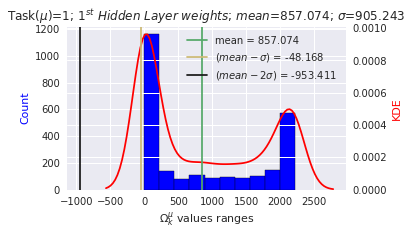

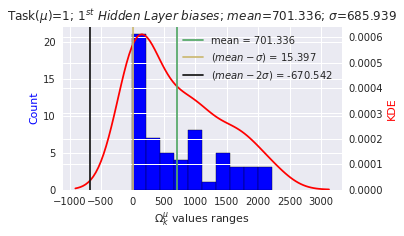

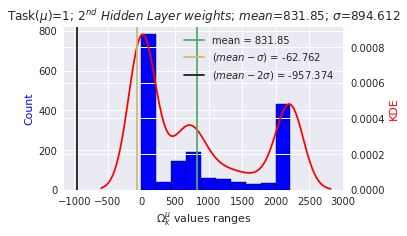

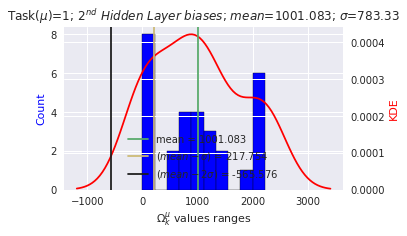

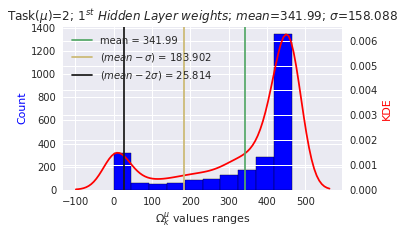

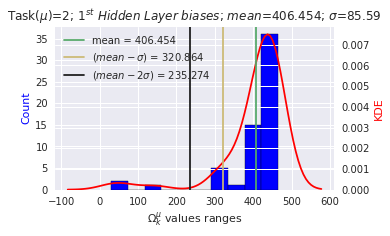

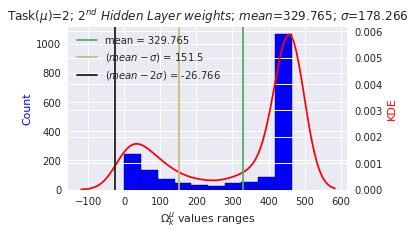

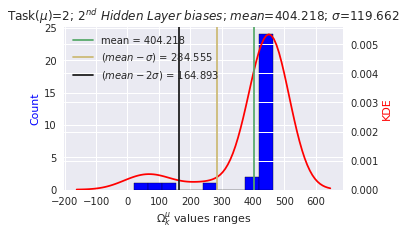

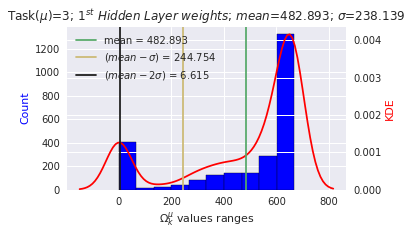

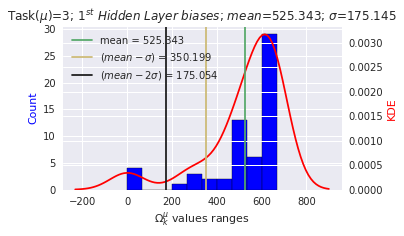

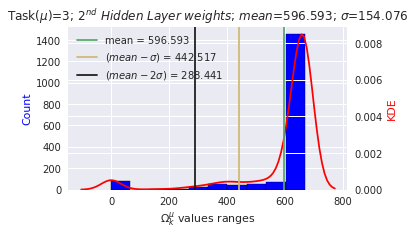

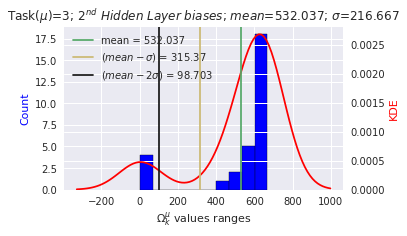

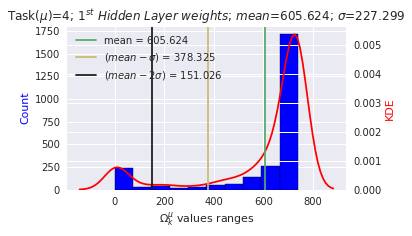

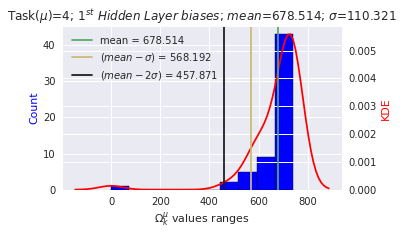

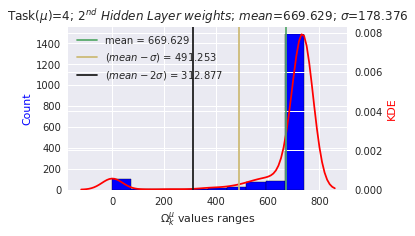

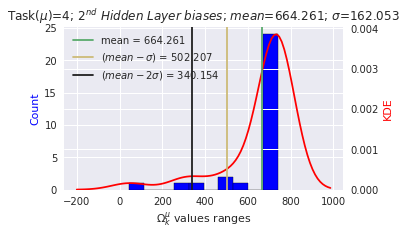

In [108]:
# histogram plot
from numpy.random import seed
from numpy.random import randn
#%matplotlib inline
from matplotlib import pyplot
import itertools
import pdb
import seaborn as sns
sns.set(color_codes=True)

for i in imp_par.keys():
    flatweights = list(itertools.chain.from_iterable(imp_par[i]['iw1'].tolist()))
    pyplot.figure(figsize=(5,3))
    pyplot.hist(flatweights, color = 'blue', edgecolor = 'black', bins=10)
    ax = sns.distplot(flatweights, bins=10, kde=False, color='blue', hist_kws={'edgecolor':'black'})
    ax.set_ylabel('Count')
    ax.set_xlabel('$\Omega^{\mu}_{k}$ values ranges')
    ax.yaxis.label.set_color('blue')
    second_ax = ax.twinx()
    sns.distplot(flatweights, ax=second_ax, kde=True, hist=False, color='red')
    second_ax.set_ylabel('KDE')
    second_ax.yaxis.label.set_color('red')
    pyplot.title('Task($\mu$)='+str(i)+'; $1^{st} \, \, Hidden \, \, Layer \, \, weights$;'+' $mean$='+str(round(np.mean(flatweights),3))+'; $\sigma$='+str(round(np.std(flatweights),3)))
    pyplot.axvline(x=round(np.mean(flatweights),3), label='mean = {}'.format(round(np.mean(flatweights),3)), c='g')
    pyplot.axvline(x=round(np.mean(flatweights),3) - round(np.std(flatweights),3), label='$(mean - \sigma)$ = {}'.format(round(np.mean(flatweights) - np.std(flatweights),3)), c='y')
    pyplot.axvline(x=round(np.mean(flatweights),3) - 2*round(np.std(flatweights),3), label='$(mean - 2\sigma)$ = {}'.format(round(np.mean(flatweights) - 2 * np.std(flatweights),3)), c='k')
    pyplot.legend()
    pyplot.savefig('ImportanceValue_w1_unsw'+str(i)+'.pdf',bbox_inches='tight')
    pylab.show()
    
    flatweights = imp_par[i]['ib1'].tolist()
    pyplot.figure(figsize=(5,3))
    pyplot.hist(flatweights, color = 'blue', edgecolor = 'black', bins=10)
    ax = sns.distplot(flatweights, bins=10, kde=False, color='blue', hist_kws={'edgecolor':'black'})
    ax.set_ylabel('Count')
    ax.set_xlabel('$\Omega^{\mu}_{k}$ values ranges')
    ax.yaxis.label.set_color('blue')
    second_ax = ax.twinx()
    sns.distplot(flatweights, ax=second_ax, kde=True, hist=False, color='red')
    second_ax.set_ylabel('KDE')
    second_ax.yaxis.label.set_color('red')
    pyplot.title('Task($\mu$)='+str(i)+'; $1^{st} \, \, Hidden \, \, Layer \, \, biases$;'+' $mean$='+str(round(np.mean(flatweights),3))+'; $\sigma$='+str(round(np.std(flatweights),3)))
    pyplot.axvline(x=round(np.mean(flatweights),3), label='mean = {}'.format(round(np.mean(flatweights),3)), c='g')
    pyplot.axvline(x=round(np.mean(flatweights),3) - round(np.std(flatweights),3), label='$(mean - \sigma)$ = {}'.format(round(np.mean(flatweights) - np.std(flatweights),3)), c='y')
    pyplot.axvline(x=round(np.mean(flatweights),3) - 2*round(np.std(flatweights),3), label='$(mean - 2\sigma)$ = {}'.format(round(np.mean(flatweights) - 2 * np.std(flatweights),3)), c='k')
    pyplot.legend()
    pyplot.savefig('ImportanceValue_b1_unsw'+str(i)+'.pdf',bbox_inches='tight')
    pylab.show()
    
    flatweights = list(itertools.chain.from_iterable(imp_par[i]['iw2'].tolist()))
    pyplot.figure(figsize=(5,3))
    pyplot.hist(flatweights, color = 'blue', edgecolor = 'black', bins=10)
    ax = sns.distplot(flatweights, bins=10, kde=False, color='blue', hist_kws={'edgecolor':'black'})
    ax.set_ylabel('Count')
    ax.set_xlabel('$\Omega^{\mu}_{k}$ values ranges')
    ax.yaxis.label.set_color('blue')
    second_ax = ax.twinx()
    sns.distplot(flatweights, ax=second_ax, kde=True, hist=False, color='red')
    second_ax.set_ylabel('KDE')
    second_ax.yaxis.label.set_color('red')
    pyplot.title('Task($\mu$)='+str(i)+'; $2^{nd} \, \, Hidden \, \, Layer \, \, weights$;'+' $mean$='+str(round(np.mean(flatweights),3))+'; $\sigma$='+str(round(np.std(flatweights),3)))
    pyplot.axvline(x=round(np.mean(flatweights),3), label='mean = {}'.format(round(np.mean(flatweights),3)), c='g')
    pyplot.axvline(x=round(np.mean(flatweights),3) - round(np.std(flatweights),3), label='$(mean - \sigma)$ = {}'.format(round(np.mean(flatweights) - np.std(flatweights),3)), c='y')
    pyplot.axvline(x=round(np.mean(flatweights),3) - 2*round(np.std(flatweights),3), label='$(mean - 2\sigma)$ = {}'.format(round(np.mean(flatweights) - 2 * np.std(flatweights),3)), c='k')
    pyplot.legend()
    pyplot.savefig('ImportanceValue_w2_unsw'+str(i)+'.pdf',bbox_inches='tight')
    pylab.show()
    
    flatweights = imp_par[i]['ib2'].tolist()
    pyplot.figure(figsize=(5,3))
    pyplot.hist(flatweights, color = 'blue', edgecolor = 'black', bins=10)
    ax = sns.distplot(flatweights, bins=10, kde=False, color='blue', hist_kws={'edgecolor':'black'})
    ax.set_ylabel('Count')
    ax.set_xlabel('$\Omega^{\mu}_{k}$ values ranges')
    ax.yaxis.label.set_color('blue')
    second_ax = ax.twinx()
    sns.distplot(flatweights, ax=second_ax, kde=True, hist=False, color='red')
    second_ax.set_ylabel('KDE')
    second_ax.yaxis.label.set_color('red')
    pyplot.title('Task($\mu$)='+str(i)+'; $2^{nd} \, \, Hidden \, \, Layer \, \, biases$;'+' $mean$='+str(round(np.mean(flatweights),3))+'; $\sigma$='+str(round(np.std(flatweights),3)))
    pyplot.axvline(x=round(np.mean(flatweights),3), label='mean = {}'.format(round(np.mean(flatweights),3)), c='g')
    pyplot.axvline(x=round(np.mean(flatweights),3) - round(np.std(flatweights),3), label='$(mean - \sigma)$ = {}'.format(round(np.mean(flatweights) - np.std(flatweights),3)), c='y')
    pyplot.axvline(x=round(np.mean(flatweights),3) - 2*round(np.std(flatweights),3), label='$(mean - 2\sigma)$ = {}'.format(round(np.mean(flatweights) - 2 * np.std(flatweights),3)), c='k')
    pyplot.legend()
    pyplot.savefig('ImportanceValue_b2_unsw'+str(i)+'.pdf',bbox_inches='tight')
    pylab.show()
    

In [24]:
import h5py
print(model.summary())
model.save_weights('saved_weights.h5') #This file cannot be opend normaly to view the weghts. It can be loaded through load_model() or can be opend via hdf5 viewer

#Shape of the array containg model weights
a_list = model.get_weights()
for i in range(len(a_list)):
    print((np.array(a_list[i])).shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 60)                2640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                310       
Total params: 4,780
Trainable params: 4,780
Non-trainable params: 0
_________________________________________________________________
None
(43, 60)
(60,)
(60, 30)
(30,)
(30, 10)
(10,)


In [15]:
data = utils.load_zipped_pickle(datafile_name)
print(data)

{'std': {1.0: array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])}, 'mean': {1.0: array([[0.63744076, 0.40957379, 0.58582601, 0.55926023, 0.50007937],
       [0.84834123, 0.90354603, 0.48021097, 0.47488995, 0.51309524],
       [0.58530806, 0.90090379, 0.75706894, 0.49409369, 0.51126984],
       [0.56161137, 0.90090379, 0.77383387, 0.7104658 , 0.52015873],
       [0.56161137, 0.90090379, 0.77367344, 0.7104658 , 0.53730159]])}}


In [18]:
for k in cvals:
    for i in range(n_tasks):
        for j in range(i):
            data['mean'][k][j][i] = 0
            data['std'][k][j][i] = 0
        
print(data)

{'std': {1.0: array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])}, 'mean': {1.0: array([[0.63744076, 0.        , 0.        , 0.        , 0.        ],
       [0.84834123, 0.90354603, 0.        , 0.        , 0.        ],
       [0.58530806, 0.90090379, 0.75706894, 0.        , 0.        ],
       [0.56161137, 0.90090379, 0.77383387, 0.7104658 , 0.        ],
       [0.56161137, 0.90090379, 0.77367344, 0.7104658 , 0.53730159]])}}


In [30]:
#Reformating for the plots to show comparision between with/without prune grow
#Reformating for the plots to show comparision between with/without prune grow
#Experiment for prune/grow=0 is performed by commenting out two lines of code in run_fits method.
# They are :
#if age != 0:
#    imp_par[age] = model_prune(age, unimportant_threshold = n_tasks-age)
#Run the same process to collect mean and std of cross-validation accuracy to show the comparision plot.
data = {'mean': {0: array([[0.54265403, 0.        , 0.        , 0.        , 0.        ],
       [0.67298578, 0.82457527, 0.        , 0.        , 0.        ],
       [0.52843602, 0.82511853, 0.75759034, 0.        , 0.        ],
       [0.52843602, 0.82514322, 0.75799142, 0.73148939, 0.        ],
       [0.52843602, 0.82509384, 0.75823206, 0.73142369, 0.46587302]]), 1.0: array([[0.63744076, 0.        , 0.        , 0.        , 0.        ],
       [0.84834123, 0.90354603, 0.        , 0.        , 0.        ],
       [0.58530806, 0.90090379, 0.75706894, 0.        , 0.        ],
       [0.56161137, 0.90090379, 0.77383387, 0.7104658 , 0.        ],
       [0.56161137, 0.90090379, 0.77367344, 0.7104658 , 0.53730159]])}, 'std': {0: array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]]), 1.0: array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])}}


In [31]:
import matplotlib.colors as colors
cmap = plt.get_cmap('cool') 
cNorm  = colors.Normalize(vmin=-5, vmax=np.log(np.max(list(data['mean'].keys()))))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
print(scalarMap.get_clim())

(-5, 0.0)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


{'Backdoor': 8, 'Generic': 4, 'Normal': 3, 'Analysis': 9, 'Worms': 0, 'Shellcode': 1, 'DoS': 7, 'Fuzzers': 5, 'Exploits': 6, 'Reconnaissance': 2}


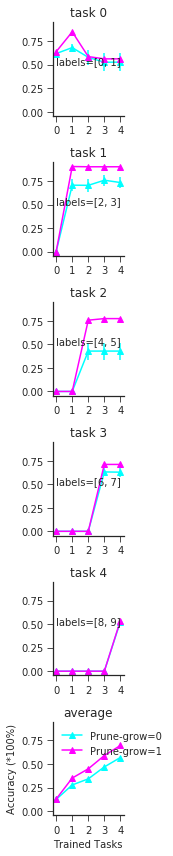

In [32]:
import pdb
figure(figsize=(2, 12))
axs = [subplot(n_tasks+1,1,1)]#, None, None]
for i in range(1, n_tasks + 1):
    axs.append(subplot(n_tasks+1,1, i+1, sharex=axs[0], sharey=axs[0]))
    
keys = list(data['mean'].keys())
sorted_keys = np.sort(keys)

for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
        colorVal = scalarMap.to_rgba(np.log(cval))
        # axs[j].plot(evals[:, j], c=colorVal)
        axs[j].errorbar(range(n_tasks), mean_vals[:, j], yerr=std_vals[:, j]/np.sqrt(n_stats), c=colorVal, marker='^')
    label = "Prune-grow=%g"%cval
    average = mean_vals.mean(1)  #Taking the average of cross validation accuracies accross all tasks after learning each task
    axs[-1].plot(average, c=colorVal, label=label,marker='^')
    axs[-1].set_xticks(np.arange(0, n_tasks, step=1))
    axs[-1].set_xlabel('Trained Tasks')
    axs[-1].set_ylabel('Accuracy (*100%)')

plt_tasklabel = task_labels[:]
plt_tasklabel.append('')
for i, ax in enumerate(axs):
    ax.legend(loc='upper left')
    ax.set_title((['task %d'%j for j in range(n_tasks)] + ['average'])[i])
    ax.text(0,0.5,('labels='+str(plt_tasklabel[i]))) if (i < len(task_labels)) else  ax.text(0,0.5,(plt_tasklabel[i]))

print(cleanup_nums)
gcf().tight_layout()
sns.despine()
plt.savefig('Prune-Dropout-UNSW.pdf',bbox_inches='tight')

In [33]:
for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
       print(mean_vals[:, j],std_vals[:, j]/np.sqrt(n_stats))

[0.61753555 0.68104265 0.57748815 0.52582938 0.52630332] [0.01685032 0.04033201 0.08171752 0.09298794 0.0930308 ]
[0.         0.705403   0.70364234 0.7579193  0.73351442] [0.         0.06317478 0.07217128 0.05700348 0.05753426]
[0.         0.         0.42868488 0.42882525 0.42872097] [0.         0.         0.09056088 0.09060003 0.09050821]
[0.         0.         0.         0.63085211 0.62827015] [0.         0.         0.         0.04574086 0.04641255]
[0.        0.        0.        0.        0.5268254] [0.         0.         0.         0.         0.01154362]
[0.63744076 0.84834123 0.58530806 0.56161137 0.56161137] [0. 0. 0. 0. 0.]
[0.         0.90354603 0.90090379 0.90090379 0.90090379] [0. 0. 0. 0. 0.]
[0.         0.         0.75706894 0.77383387 0.77367344] [0. 0. 0. 0. 0.]
[0.        0.        0.        0.7104658 0.7104658] [0. 0. 0. 0. 0.]
[0.         0.         0.         0.         0.53730159] [0. 0. 0. 0. 0.]


In [34]:
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

def simple_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()


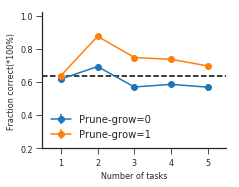

In [35]:
#Fractional Correctness = Average of cross validation accuracies of learned tasks only after training each task 
fig = plt.figure(figsize=(3.3,2.5))
ax = plt.subplot(111)

for cval in sorted_keys:
    mean_stuff = []
    std_stuff = []
    for i in range(len(data['mean'][cval])):
        mean_stuff.append(data['mean'][cval][i][:i+1].mean())
        std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))
    # plot(range(1,n_tasks+1), mean_stuff, 'o-', label="c=%g"%cval)
    errorbar(range(1,n_tasks+1), mean_stuff, yerr=std_stuff, fmt='o-', label="Prune-grow=%g"%cval)
        
axhline(data['mean'][cval][0][0], linestyle='--', color='k')
xlabel('Number of tasks')
ylabel('Fraction correct(*100%)')
legend(loc='best')
xlim(0.5, n_tasks+0.5)
ylim(0.2, 1.02)
# grid('on')
# sns.despine()
simple_axis(ax)
plt.savefig('Prune-Dropout-UNSW-fractionalcorrect.pdf',bbox_inches='tight')